In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.datasets import mnist
import keras
np.random.seed(25)

Using TensorFlow backend.


In [2]:
print(keras.__version__)

2.2.4


In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

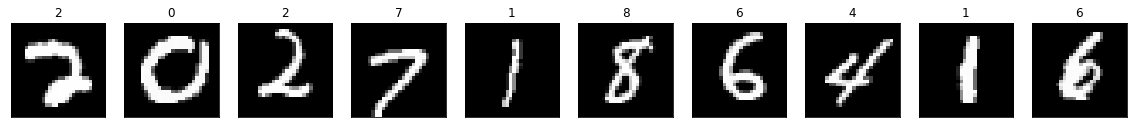

In [4]:
fig, axes = plt.subplots(ncols=10, sharex=False,
    sharey=True, figsize=(20, 7))
counter = 0
for i in range(120, 130):
    axes[counter].set_title(y_train[i])
    axes[counter].imshow(X_train[i], cmap='gray')
    axes[counter].get_xaxis().set_visible(False)
    axes[counter].get_yaxis().set_visible(False)
    counter += 1
plt.show()

In [5]:
X_train = X_train/255
X_test = X_test/255

In [6]:
# Convert from (no_of_data, 28, 28) to (no_of_data, 28, 28, 1)
X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_new = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_train_new.shape)
print(X_test_new.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [7]:
img_height, img_width, num_channels = X_train_new.shape[1:]
input_shape =  (img_height, img_width, num_channels)
latent_dim = 2

In [8]:
encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2,padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2,padding='same', activation='relu')(encoder_conv)

encoder = Flatten()(encoder_conv)
mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

In [9]:
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

In [10]:
latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])

In [11]:
conv_shape = K.int_shape(encoder_conv)
print(conv_shape)

(None, 7, 7, 16)


In [12]:
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)

decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)
decoder_conv = Conv2DTranspose(filters=num_channels, kernel_size=3, padding='same', activation='sigmoid')(decoder_conv)

In [13]:
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
encoder.summary()
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 16)     1168        conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

In [14]:
vae = Model(encoder_input, decoder(encoder(encoder_input)))
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 4388      
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         5905      
Total params: 10,293
Trainable params: 10,293
Non-trainable params: 0
_________________________________________________________________


In [15]:
def kl_reconstruction_loss(true, pred):    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

In [16]:
vae.compile(optimizer='adam', loss=kl_reconstruction_loss, metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
history = vae.fit(x=X_train_new, y=X_train_new, epochs=20, batch_size=32, validation_data=(X_test_new,X_test_new))




Train on 60000 samples, validate on 10000 samples
Epoch 1/20





60000/60000 [==============================] - 15s 253us/step - loss: 190.0412 - acc: 0.7986 - val_loss: 172.3737 - val_acc: 0.7868
Epoch 2/20
60000/60000 [==============================] - 13s 217us/step - loss: 168.7551 - acc: 0.7895 - val_loss: 166.4890 - val_acc: 0.7941
Epoch 3/20
60000/60000 [==============================] - 13s 220us/step - loss: 164.2463 - acc: 0.7929 - val_loss: 162.7797 - val_acc: 0.7946
Epoch 4/20
60000/60000 [==============================] - 13s 219us/step - loss: 162.0993 - acc: 0.7940 - val_loss: 161.3341 - val_acc: 0.7960
Epoch 5/20
60000/60000 [==============================] - 13s 224us/step - loss: 160.9746 - acc: 0.7946 - val_loss: 160.3135 - val_acc: 0.7930
Epoch 6/20
49760/60000 [=======================>......] - ETA: 2s - loss: 160.4099 - acc: 0.7948

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
encoded = encoder.predict(X_train_new)

In [ ]:
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, c=y_train, cmap='hsv')
plt.colorbar()
plt.grid()
plt.show()

In [ ]:
def plot_latent_space(decoder, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(decoder)